In [1]:
import pandas as pd
import sqlite3
from ipywidgets import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

def idxwhere(x):
    return x[x].index

In [2]:
from collections import defaultdict

from scripts.lib.plotting import load_style

loaded_style = load_style('paper')
savefig = loaded_style['savefig']
fullwidth = loaded_style['fullwidth']
halfwidth = loaded_style['halfwidth']

In [3]:
def rename_feature(feature_id, mag_names):
    for mag in mag_names:
        if feature_id.startswith(mag):
            return feature_id.replace(mag, mag_names[mag])
    else:
        return feature_id
    
def HArrow(start, end, y, width, head_length=0, **kwargs):
    dx = end - start
    assert head_length < np.abs(dx), "Head length too long. {} > {}".format(head_length, np.abs(dx))
    return mpl.patches.FancyArrow(x=start, y=y, dx=dx, dy=0, width=width, head_length=head_length,
                                  length_includes_head=True, **kwargs)

def color_map_from_labels(labels, cm, default_color=None, offset=0):
    labels = set(labels)
    if isinstance(cm, mpl.colors.Colormap):
        cm = defaultdict(lambda: default_color, zip(labels, cm(np.linspace(0, 1, len(labels) + offset))))
    return cm

def plot_genomic_region(feature_df, domain_df=None,
                        feature_colorby='feature_colorby',
                        feature_annotate=None,
                        feature_cm=None, 
                        domain_colorby='domain_colorby',
                        domain_cm=None,
                        ax=None,
                        arrowhead_aspect=0.002,
                        add_legend=True,
                        feature_legend='Features',
                        domain_legend='Domains'
                       ):
    """
    
    feature_df[['feature_id', 'feature_start', 'feature_stop', *feature_colorby*, *feature_annotate*]]
    domain_df[['domain_start', 'domain_stop', *domain_colorby*]]

    """
    if domain_df is None:
        domain_df = pd.DataFrame([], columns=['domain_id', 'domain_start', 'domain_stop', domain_colorby])
        
    if not feature_cm:
        feature_cm = mpl.cm.Paired
    if not domain_cm:
        domain_cm = mpl.cm.Set3
    feature_cm = color_map_from_labels(feature_df[feature_colorby].dropna(), feature_cm)
    domain_cm = color_map_from_labels(domain_df[domain_colorby].dropna(), domain_cm)
    
    if not ax:
        fig, ax = plt.subplots(figsize=(16, 4))
        
    region_left = feature_df[['feature_start', 'feature_stop']].min().min()
    region_right = feature_df[['feature_start', 'feature_stop']].max().max()
    arrow_width = 0.6
    region_width = region_right - region_left
    head_length = region_width * arrowhead_aspect / arrow_width
    ax.set_xlim(region_left - 4 * head_length,
                region_right + 4 * head_length)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    
    ax.plot([region_left, region_right], [0, 0], color='k')
    
    for _, ft in feature_df.iterrows():
        ax.add_patch(HArrow(ft.feature_start, ft.feature_stop,
                            arrow_width * ft.strand * 1/2,
                            width=arrow_width, head_width=arrow_width,
                            head_length=head_length,
                            facecolor=feature_cm[ft[feature_colorby]],
                            edgecolor='black'))
        ax.annotate(ft.feature_id,
                    (ft[['feature_start', 'feature_stop']].mean(),
                     (arrow_width + 0.08) * ft.strand),
                    ha='center', va='center', fontweight='bold',
                    fontsize=6, clip_on=True)
        if feature_annotate:
            ax.annotate(ft[feature_annotate],
                       (ft[['feature_start', 'feature_stop']].mean()
                       , arrow_width * ft.strand * 1/2)
                       , ha='center', va='center'
#                       , rotation=-90
                       , color='black'
                       , fontsize=7
                       )
        
    for _, dm in domain_df.iterrows():
        ax.add_patch(HArrow(dm.domain_start, dm.domain_stop,
                            arrow_width * 1/8 * dm.strand,
                            width=arrow_width / 4,
                            head_width=arrow_width / 4,
                            head_length=0,
                            facecolor=domain_cm[dm[domain_colorby]],
                            edgecolor='black'))    

    if feature_legend:
        feature_artists = []
        for lbl in feature_cm:
            if lbl is None:
                continue
            feature_artists.append(ax.add_patch(HArrow(-1, -2, 0, 2, facecolor=feature_cm[lbl], label=lbl)))
        feature_legend = ax.legend(handles=feature_artists, loc='lower left', title=feature_legend)
        ax.add_artist(feature_legend)
        
    if domain_legend:
        domain_artists = []
        for lbl in domain_cm:
            if lbl is None:
                continue
            domain_artists.append(ax.add_patch(HArrow(-1, -2, 0, 2, facecolor=domain_cm[lbl], label=lbl)))
        domain_legend = ax.legend(handles=domain_artists, loc='lower right', title=domain_legend, ncol=3, fontsize=7, title_fontsize=8)
        ax.add_artist(domain_legend)


In [4]:
color_map = {
    'GH13': 'darkblue'
  , 'CBM20': 'darkgreen'
  , 'GH97': 'lightblue'
  , 'GH31': 'lightpink'
  , 'GH57': 'lightpink'
  , 'GH70': 'lightpink'
  , 'GH77': 'lightpink'
  , 'CBM69': 'lightgreen'
  , 'CBM26': 'plum'
  , 'GH66': 'khaki'
}

In [5]:
con = sqlite3.connect('data/core.muri2.2.denorm.db')

In [6]:
mag = pd.read_sql("""
    SELECT
        genome_id
      , genome_type
      , completeness
      , contamination
      , n_contigs
      , total_length
      , gc_percent
      , n50
    FROM genome
    JOIN checkm USING (genome_id)
    JOIN quast USING (genome_id)
                  """, con=con,
                  index_col=['genome_id'])

mag_names = { 'Otu0001_vC': 'B1-A'
            , 'Otu0001_vB': 'B1-B'
            , 'Otu0007_vA': 'B2'
            , 'Otu0004_vA': 'B3'
            , 'Otu0005_vA': 'B4'
            , 'Otu0009_vA': 'B5'
            , 'Otu0017_vA': 'B6'
            , 'Otu0049_vA': 'B7'
            }

In [7]:
pul = pd.read_sql("""
    SELECT
        sequence_id
      , feature_id
      , feature_start
      , feature_stop
      , susC
      , susD
      , susEF
      , domain_id
      , cmd.domain_start AS domain_start_aa
      , cmd.domain_stop AS domain_stop_aa
      , localization
      , opf_id
      , architecture
      , product_description
    FROM closest_PUL_susC
    JOIN feature_details AS fd USING (feature_id)
    LEFT JOIN (SELECT feature_id, 1 AS susC FROM susC) AS c USING (feature_id)
    LEFT JOIN (SELECT feature_id, 1 AS susD FROM susD) AS d USING (feature_id)
    LEFT JOIN (SELECT feature_id, 1 AS susEF FROM susEF) AS e USING (feature_id)
    LEFT JOIN (SELECT * FROM feature_x_cazy_minimal_domain WHERE score > 5.) AS cmd USING (feature_id)
    WHERE distance < 25000
                  """, con=con)

pul['feature_left'] = pul[['feature_start', 'feature_stop']].min(1)
pul['feature_right'] = pul[['feature_start', 'feature_stop']].max(1)
pul['strand'] = (pul.feature_start < pul.feature_stop).map({True: 1, False: -1})
pul['domain_start'] = pul.feature_start + (pul.domain_start_aa * 3 * pul.strand)
pul['domain_stop'] = pul.feature_start + (pul.domain_stop_aa * 3 * pul.strand)
pul[['susC', 'susD', 'susEF']] = pul[['susC', 'susD', 'susEF']].fillna(0).astype(bool)
pul.loc[pul.domain_id.replace({None: ''}).str.startswith('GH13_'), 'domain_id'] = 'GH13'

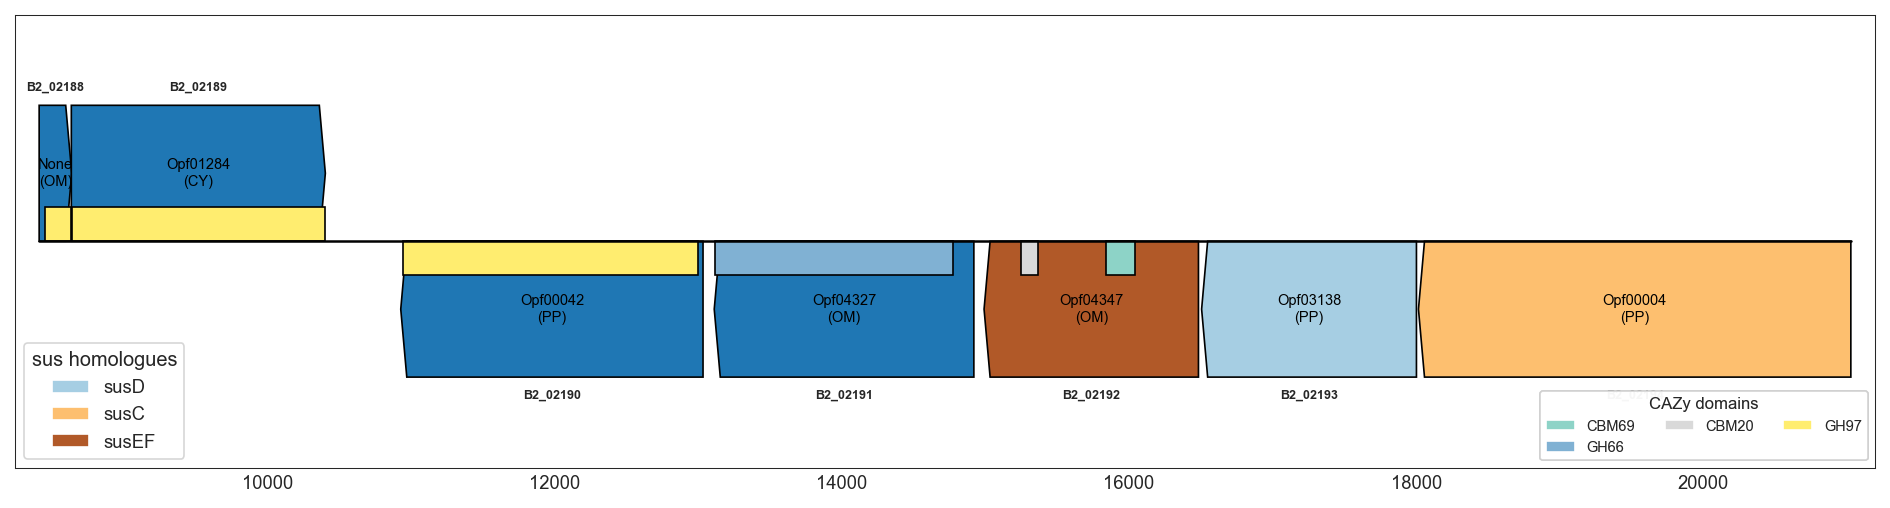

In [8]:
sequence_id, region_left, region_right = ('B2.112', 8411, 21027)
d = pul[ (pul.sequence_id == sequence_id)
       & (pul.feature_right > region_left)
       & (pul.feature_left < region_right)
       ].drop_duplicates()

f = d[['feature_id', 'feature_start', 'feature_stop', 'strand', 'susC', 'susD', 'susEF', 'opf_id', 'localization']].drop_duplicates()

f['feature_colorby'] = None
f.loc[lambda x: x.susEF, 'feature_colorby'] = 'susEF'
f.loc[lambda x: x.susD, 'feature_colorby'] = 'susD'
f.loc[lambda x: x.susC, 'feature_colorby'] = 'susC'
f['annotate'] = f.apply(lambda x: '{}\n({})'.format(x.opf_id, x.localization), axis=1)
f.feature_id = f.feature_id.str.replace('B1A_', '')

plot_genomic_region(f, d.dropna(subset=['domain_id']),
                    feature_annotate='annotate',
                    domain_colorby='domain_id',
                    feature_legend='sus homologues',
                    domain_legend='CAZy domains')

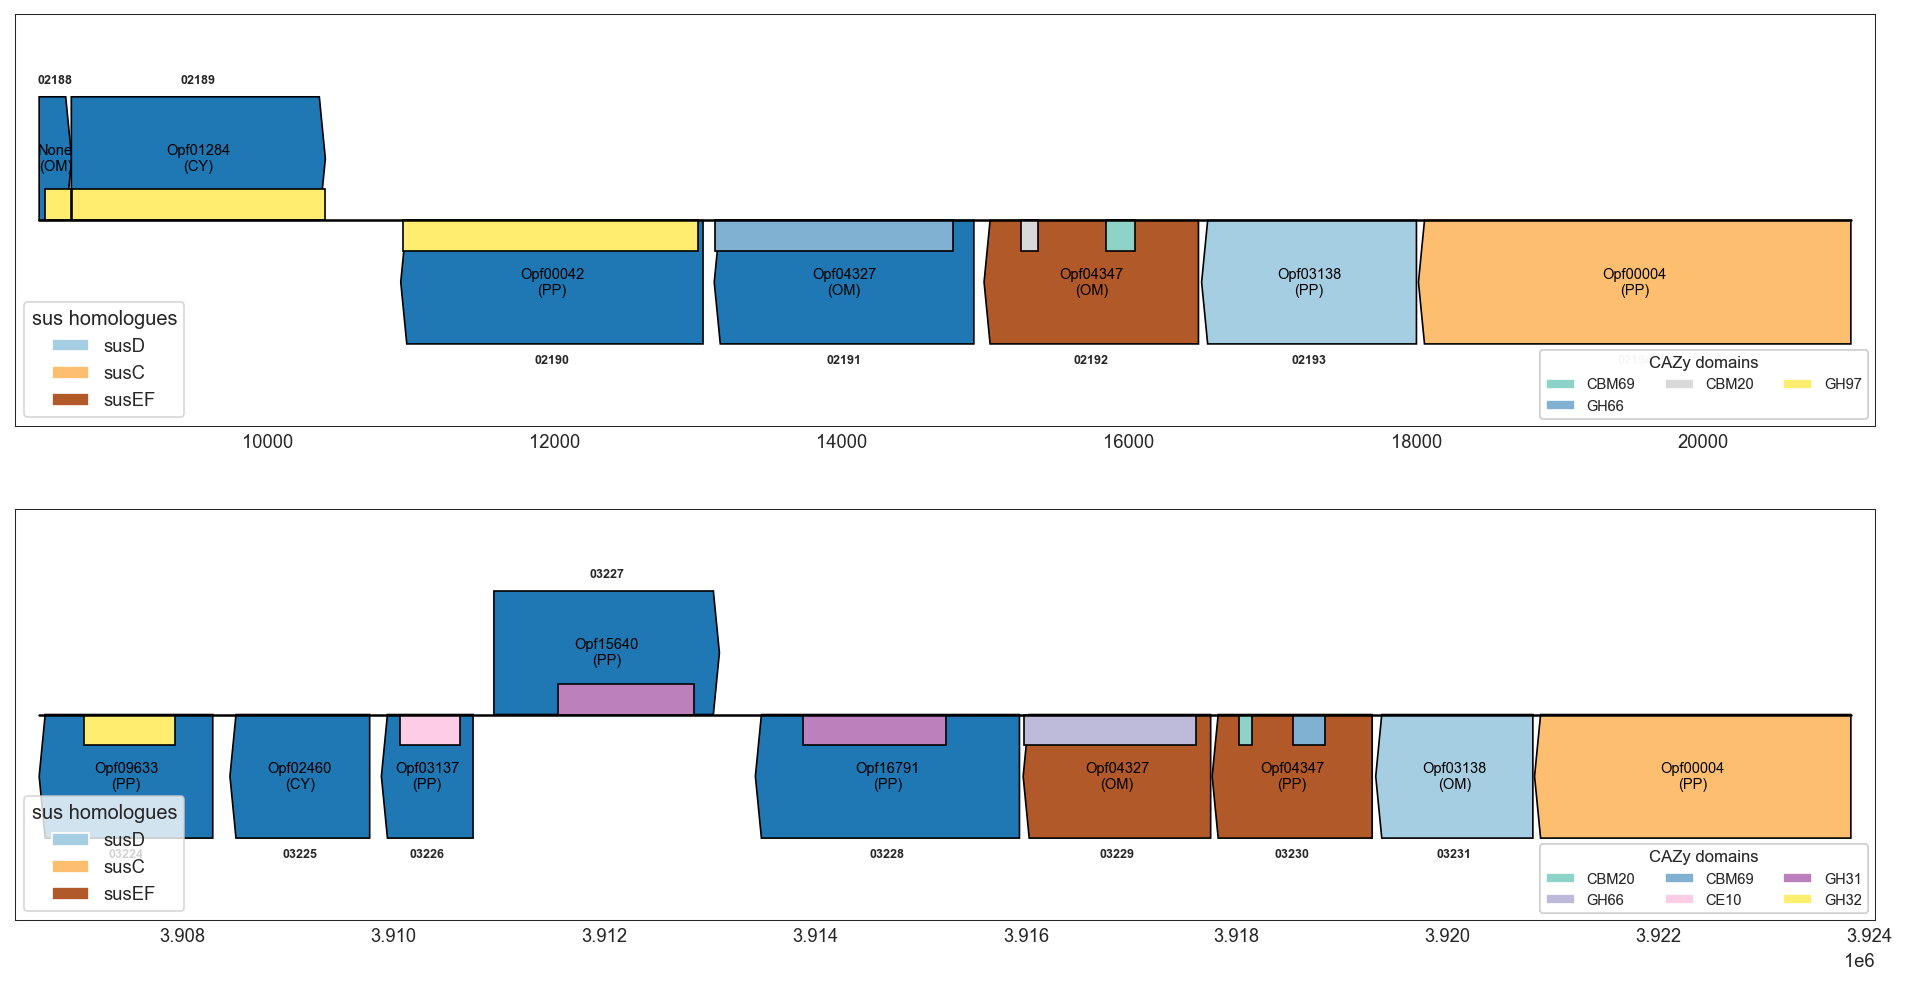

In [9]:
fig, axs = plt.subplots(2, figsize=(16, 8))

regions = [ ('B2', 'B2.112', 8411, 21027, axs[0])
          , ('Bacteroides_thetaiotaomicron_VPI5482', 'AE015928.1', 3906644, 3923822, axs[1])
          ]

for genome_id, sequence_id, region_left, region_right, ax in regions:
    d = pul[ (pul.sequence_id == sequence_id)
           & (pul.feature_right > region_left)
           & (pul.feature_left < region_right)
           ].drop_duplicates()
    f = d[['feature_id', 'feature_start', 'feature_stop', 'strand', 'susC', 'susD', 'susEF', 'opf_id', 'localization']].drop_duplicates()
    f['feature_colorby'] = None
    f.loc[lambda x: x.susEF, 'feature_colorby'] = 'susEF'
    f.loc[lambda x: x.susD, 'feature_colorby'] = 'susD'
    f.loc[lambda x: x.susC, 'feature_colorby'] = 'susC'
    f['annotate'] = f.apply(lambda x: '{}\n({})'.format(x.opf_id, x.localization), axis=1)
    f.feature_id = f.feature_id.str.replace(genome_id + '_', '')
    plot_genomic_region(f, d.dropna(subset=['domain_id']),
                        feature_annotate='annotate',
                        domain_colorby='domain_id',
                        feature_legend='sus homologues',
                        domain_legend='CAZy domains', ax=ax)

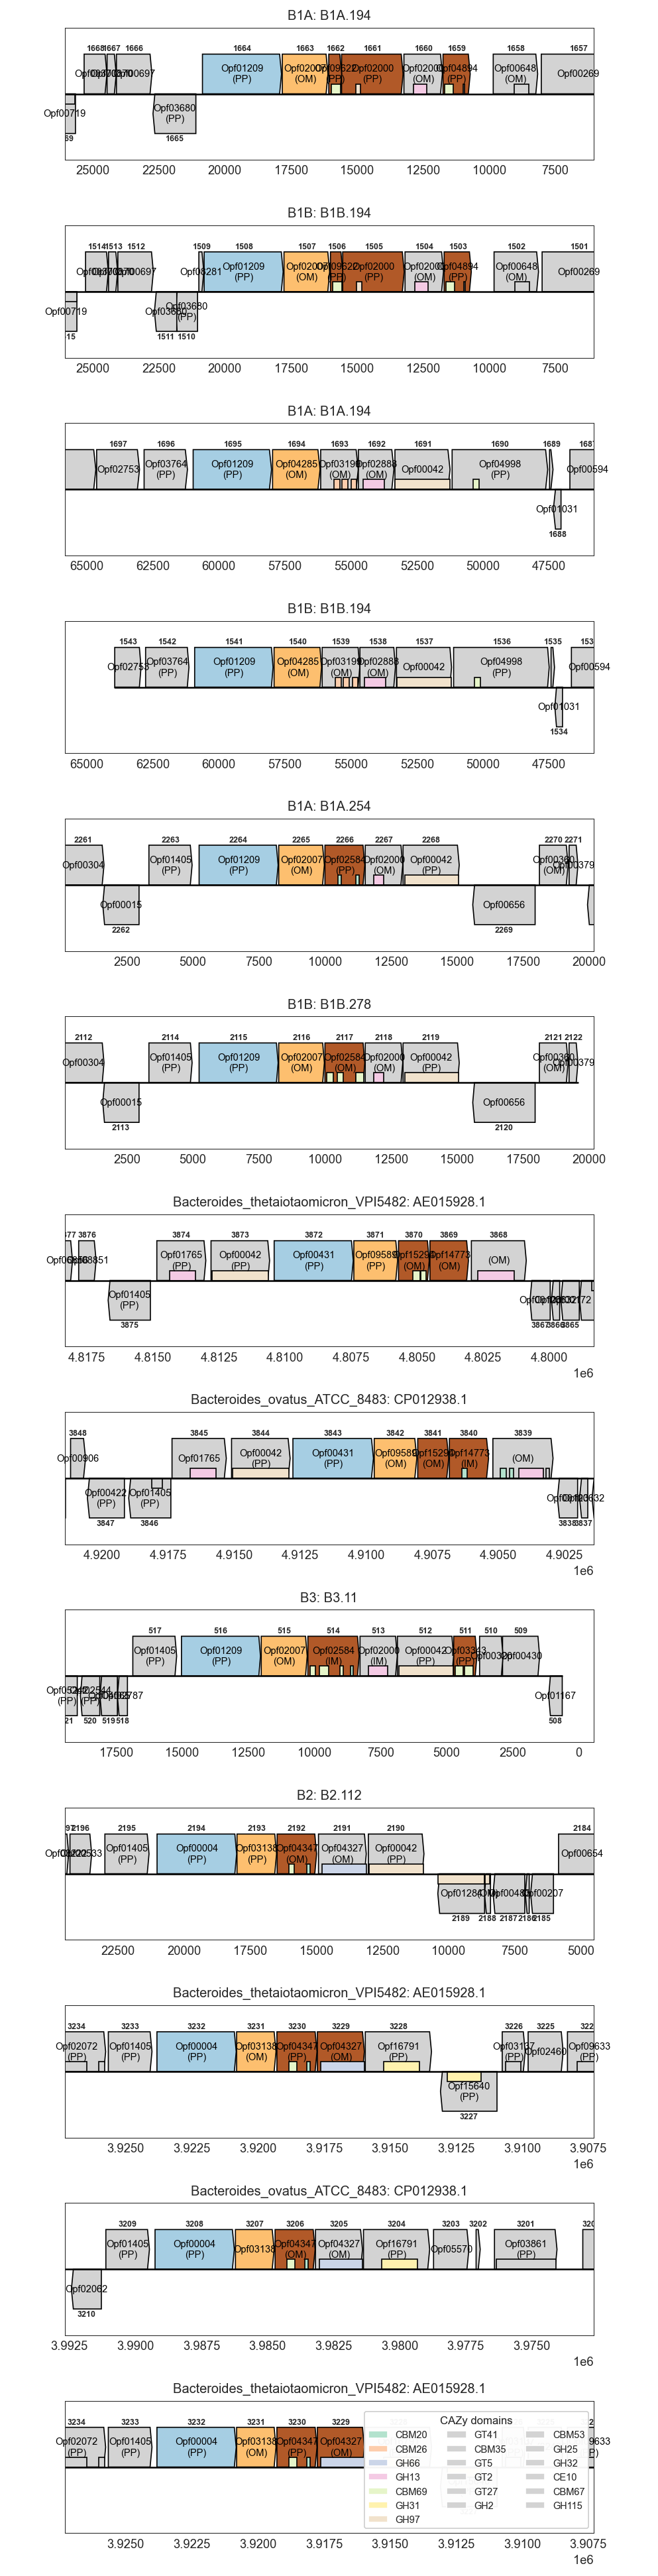

In [12]:
domain_cmap = color_map_from_labels(['GH13', 'GH31', 'GH97', 'GH66', 'CBM20', 'CBM69', 'CBM26'],
                                    mpl.cm.Pastel2, default_color='lightgrey', offset=2)
feature_cmap = color_map_from_labels(['susC', 'susD', 'susEF'],
                                     mpl.cm.Paired, default_color='lightgrey')

opf_annot_list = [
#    'Opf00023', 'Opf01229', 'Opf01840', 'Opf01642', 'Opf02156'
]

regions = [ ('B1A', 'B1A.194', 8001 - 2000, 24114 + 2000, False, False)
          , ('B1B', 'B1B.194', 8001 - 2000, 24114 + 2000, False, False)
           
          , ('B1A', 'B1A.194', 46996 - 2000, 64653 + 2000, False, False)
          , ('B1B', 'B1B.194', 46996 - 2000, 64653 + 2000, False, False)
           
          , ('B1A', 'B1A.254', 5234 - 2000, 15076 + 2000, False, False)
          , ('B1B', 'B1B.278', 5234 - 2000, 15076 + 2000, False, False)  # B1B _slightly_ different PUL than B1A
           
          , ('Bacteroides_thetaiotaomicron_VPI5482', 'AE015928.1', 4799968 - 2000, 4816693 + 2000, False, False)  # B.t. Starch PUL with Opf1406
          , ('Bacteroides_ovatus_ATCC_8483', 'CP012938.1', 4901623 - 2000, 4921191 + 2000, False, False)  # B.o. Starch PUL with Opf1406

          , ('B3', 'B3.11', 3851 - 2000, 15029 + 2000, False, False)  # B3 exported GH13 (but inner membrane)
           
           
          , ('B2', 'B2.112', 6029 - 2000, 23001 + 2000, False, False)  # B2 maybe starch active? (GH66)
          , ('Bacteroides_thetaiotaomicron_VPI5482', 'AE015928.1', 3906644 - 2000, 3927967 + 2000, False, False)  # B.t. dextran PUL with GH66
          , ('Bacteroides_ovatus_ATCC_8483', 'CP012938.1', 3974048 - 2000, 3991288 + 2000, False, False)  # B.o. dextran PUL with GH66
           
          , ('Bacteroides_thetaiotaomicron_VPI5482', 'AE015928.1', 3906644 - 2000, 3927967 + 2000, False, 'CAZy domains')  # Dummy ax

          ]

fig, axs = plt.subplots(len(regions), figsize=(fullwidth, 2 * len(regions)))

for (genome_id, sequence_id, region_left, region_right, feature_legend, domain_legend), ax in zip(regions, axs):
    # Re-orient the region
    region_anchor = (region_left + region_right) / 2
    region_left = region_anchor - 10000
    region_right = region_anchor + 10000
    
    d = pul[ (pul.sequence_id == sequence_id)
           & (pul.feature_right > region_left)
           & (pul.feature_left < region_right)
           ].drop_duplicates()
    f = d[[
        'feature_id', 'feature_start',
        'feature_stop', 'strand', 'susC',
        'susD', 'susEF',
        'opf_id', 'localization'
    ]].drop_duplicates()
    f['feature_colorby'] = None
    f.loc[lambda x: x.susEF, 'feature_colorby'] = 'susEF'
    f.loc[lambda x: x.susD, 'feature_colorby'] = 'susD'
    f.loc[lambda x: x.susC, 'feature_colorby'] = 'susC'
    
    def _annotate_feature(f):
        annot = []
#         if f.opf_id in opf_annot_list:
#             annot.append(f.opf_id)
        if not f.opf_id is None:
            annot.append(f.opf_id)
        if f.localization != 'CY':
            annot.append('(' + f.localization + ')')
        return '\n'.join(annot)

    f['annotate'] = f.apply(_annotate_feature, axis=1)
    f.feature_id = f.feature_id.str.replace(genome_id + '_', '').str.lstrip('0')
    plot_genomic_region(f, d.dropna(subset=['domain_id']),
                        feature_annotate='annotate',
                        domain_colorby='domain_id',
                        domain_cm=domain_cmap,
                        feature_cm=feature_cmap,
                        feature_legend=feature_legend,
                        domain_legend=domain_legend,
                        ax=ax)
    ax.set_xlim(region_left, region_right)
    if d.strand.sum() < 0:
        ax.invert_xaxis()
        ax.invert_yaxis()
    ax.set_title('{}: {}'.format(genome_id, sequence_id))
    
fig.tight_layout()
# fig.savefig('build/starch_related_PULs.svg', dpi=250, bbox_inches='tight')
fig.savefig('fig/starch_related_PULs.pdf', dpi=250, bbox_inches='tight')